### Tracking PQs topics

This notebook explores ways of tracking and analysing the topics that are the subject of PQs by MPs and Peers

In [1]:
import requests
import json
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import os
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

#### Import and clean up data

We'll import some data on MPs, so that - if we want to - we can find out more about who is asking about what. Then we'll import all PQs (unanswered & answered). 

We clean up the PQs data, too. 

In [2]:
active_p = pd.read_csv('active_members.csv')
former_p = pd.read_csv('former_members.csv')

all_p = pd.concat([active_p, former_p])
all_p = all_p[['id', 'nameListAs', 'gender', 'latestPartyabbreviation']]

id_party_dict = dict(zip(all_p.id, all_p.latestPartyabbreviation))

In [3]:
wpqs = pd.read_csv('tmp/ua_pqs.csv')
wpqs['dateTabled'] = pd.to_datetime(wpqs.dateTabled)
wpqs['heading'] = wpqs.heading.fillna('')
# wpqs = wpqs[['id', 'askingMemberId', 'askingMember', 'house', 'dateTabled', 'questionText', 'answeringBodyName', 'heading']]

# Populate a column with party appreviation in the WPQs database
wpqs['latestPartyabbreviation'] = wpqs.askingMemberId.progress_apply(lambda x: id_party_dict[x] if x in id_party_dict.keys() else 'n/a')

# Make some of the string fields lower case to improve comparability and searchability
wpqs['heading'] = wpqs.heading.progress_apply(lambda x: x.lower())
wpqs['questionText'] = wpqs.questionText.progress_apply(lambda x: x.lower())

# Sometime the heading is a generic topic, other times it's specified by a ":" symbol. We'll extract this into a 'topic' column.
wpqs['topic'] = wpqs.heading.progress_apply(lambda x: x.split(':')[0])

wpqs['year_month'] = wpqs.dateTabled.dt.to_period('M')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 385097/385097 [00:00<00:00, 1362046.26it/s]


In [4]:
wpqs.head()

,id,askingMemberId,askingMember,house,memberHasInterest,dateTabled,dateForAnswer,uin,questionText,answeringBodyId,answeringBodyName,heading,latestPartyabbreviation,topic,year_month
0,58429,437,NaN,Commons,False,2014-06-05,2014-06-09T00:00:00,199151,"to ask mr chancellor of the exchequer, how muc...",14,HM Treasury,working tax credit: bolton,Lab,working tax credit,2014-06
1,57913,4031,NaN,Commons,False,2014-06-04,2014-06-09T00:00:00,198956,"to ask mr chancellor of the exchequer, what th...",14,HM Treasury,welfare tax credits,Lab,welfare tax credits,2014-06
2,61038,4031,NaN,Commons,False,2014-06-10,2014-06-16T00:00:00,199850,"to ask mr chancellor of the exchequer, what th...",14,HM Treasury,welfare tax credits,Lab,welfare tax credits,2014-06
3,64002,163,NaN,Commons,False,2014-06-25,2014-06-30T00:00:00,202509,"to ask mr chancellor of the exchequer, how man...",14,HM Treasury,welfare tax credits: self-employed,Lab,welfare tax credits,2014-06
4,64577,385,NaN,Commons,False,2014-06-27,2014-07-01T00:00:00,202934,"to ask mr chancellor of the exchequer, how man...",14,HM Treasury,welfare tax credits: york,Lab,welfare tax credits,2014-06


#### Exploratory analysis

Let's make a word cloud of a particular day's PQs. 

In [5]:
from wordcloud import WordCloud

In [115]:
# Set the date here

date = '2019-01'

In [116]:
# Filter out the Lords, whose questions take a different format
wpqs_sel = wpqs[wpqs.house == 'Commons']

# Make a long string of all the questions. 

# Each question starts in the form "To ask the secretary of state for X, what [question text]". We'll get the bit after the "what, "
# question_list = wpqs_sel[wpqs_sel.dateTabled == date].questionText.tolist()
question_list = wpqs_sel[wpqs_sel.year_month == date].questionText.tolist()

question_list = [x.replace(', and', ' and') for x in question_list]
question_list = [x.replace('foreign, commonwealth and development affairs', 'foreign commonwealth and development affairs') for x in question_list]
question_list = [x.replace('digital, culture, media', 'digital culture media') for x in question_list]
question_list = [x.replace('business, energy and industrial', 'business energy and industrial') for x in question_list]
question_list = [x.replace('levelling up, housing and', 'levelling up housing and') for x in question_list]
question_list = [x.replace('environment, food and rural affairs', 'environment food and rural affairs') for x in question_list]
question_list = [x.split(', ') for x in question_list]


# Go through divided question_list and append the substantive bit (second element in list) to a blank list
question_text = []
for q in question_list:
    question_text.append(''.join(q[1:]))
    
# # Clean out a few meaningless words that appear over and over
question_text = [x.replace('.', ' ').replace(' take ', ' ').replace('agencies remove', ' ').replace(' department ', ' ').replace('publish', '').replace(' government ', ' ').replace('pursuant', '').replace('question', '').replace('answer', '').replace('reference', '').replace(' effect ', ' ').replace(' make ', ' ').replace(' ensure ', ' ').replace('steps', '').replace(' assessment ', ' ').replace('taking', '').replace('made', '').replace('will', '') for x in question_text]
question_text = [x.replace('many', '').replace('whether', '').replace('(b)', '').replace('(a)', '') for x in question_text]
question_text = [x.replace('people', '').replace(' support ', ' ').replace(' s ', '').replace(' plans ', ' ').replace(' plan ', ' ') for x in question_text]
question_text = [x.replace(' application ', ' ').replace(' applications ', ' ').replace(' level ', ' ').replace(' help ', ' ').replace(' administration ', ' ').replace(' discussion ', ' ').replace(' service ', '').replace('communities', '').replace(' discussions ', '').replace(' impact ', '').replace('january', '').replace('february', '').replace(' uk ', ' ').replace('recent', '').replace(' estimate ', ' ').replace(' number ', ' ').replace(' c ', '') for x in question_text]
question_text = [x.replace('department', '').replace(' proportion ', ' ').replace(' department ', ' ').replace(' england ', ' ').replace('potential merits', ' ').replace(' national ', ' ').replace(' may ', ' ').replace(' statement ', ' ').replace(' year ', ' ').replace('(c)', ' ') for x in question_text]
question_text = [x.replace(' april ', ' ') for x in question_text]

long_string = ', '.join(question_text)

In [117]:
wordcloud = WordCloud(
    background_color='white', 
    max_words = 5000, 
    contour_width=3, 
    contour_color='steelblue', 
    width = 1000, 
    height=500
)


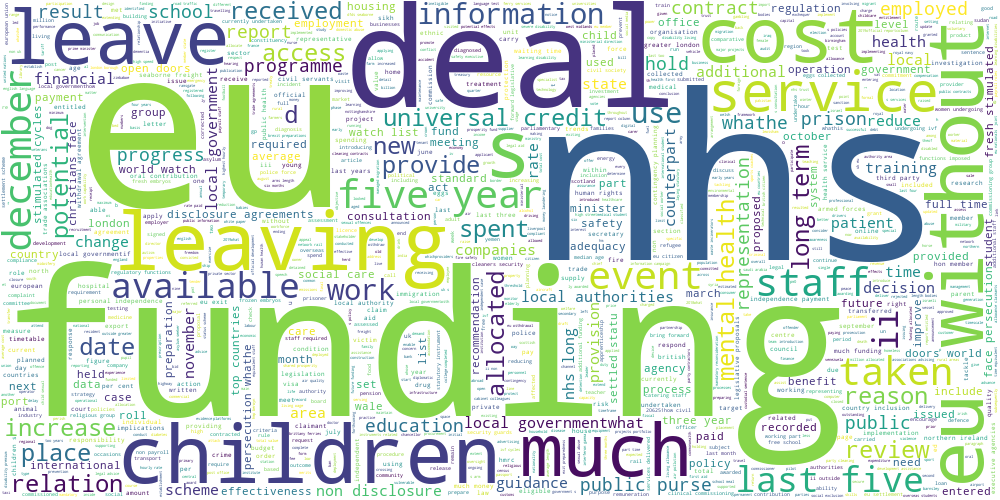

In [118]:
wordcloud.generate(long_string)
wordcloud.to_image()

### Latent Dirichlet Allocation LDA analysis

In [119]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora

from pprint import pprint

[nltk_data] Downloading package stopwords to /home/ben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
pqs_stop_words = ['from', 'subject', 're', 'edu', 'use', 'assessment', 'department', 'made', 'make', 'whether', 'government', 'estimate', 'steps', 'taking', 'discussions', 'regarding', 'february', 'january', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'plan', 'ensure',
                 'proportion', 'implication', 'policies', 'year', 'help', 'finding', 'number', 'guidance', 'reference', 'potential', 'report', 'applications',]

In [121]:
stop_words = stopwords.words('english')
stop_words.extend(pqs_stop_words)

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


In [122]:
data = question_text
data_words = list(sent_to_words(data))

In [123]:
data_words = remove_stopwords(data_words)

In [124]:
print(data_words[:1][0][:30])

['local', 'governmentwhat', 'homeless', 'sleeping', 'tents', 'cars']


In [125]:
# Create a dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Tern Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [126]:
# Number of topics 
num_topics = 20

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                      id2word=id2word,
                                      num_topics = num_topics)

# Print the keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"local" + 0.010*"years" + 0.010*"last" + 0.008*"since" + '
  '0.006*"children" + 0.006*"five" + 0.005*"reduce" + 0.005*"credit" + '
  '0.005*"public" + 0.005*"fresh"'),
 (1,
  '0.010*"health" + 0.008*"review" + 0.007*"since" + 0.007*"local" + '
  '0.007*"non" + 0.007*"staff" + 0.006*"cases" + 0.006*"work" + 0.005*"time" + '
  '0.005*"agreements"'),
 (2,
  '0.008*"whathe" + 0.008*"countries" + 0.008*"country" + 0.006*"world" + '
  '0.006*"persecution" + 0.006*"schools" + 0.006*"open" + 0.006*"list" + '
  '0.005*"christians" + 0.005*"face"'),
 (3,
  '0.013*"eu" + 0.010*"nhs" + 0.010*"services" + 0.008*"staff" + 0.007*"non" + '
  '0.005*"local" + 0.005*"trade" + 0.005*"received" + 0.004*"office" + '
  '0.004*"funding"'),
 (4,
  '0.019*"eu" + 0.009*"leaving" + 0.009*"public" + 0.008*"without" + '
  '0.007*"deal" + 0.007*"nhs" + 0.007*"health" + 0.006*"local" + '
  '0.005*"information" + 0.005*"agreements"'),
 (5,
  '0.020*"eu" + 0.015*"deal" + 0.015*"without" + 0.012*"years" 

In [127]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/home/ben/miniconda3/envs/lan/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.053621  0.088417       1        1  6.127643
13    -0.077061 -0.034628       2        1  6.095627
5     -0.055825 -0.121323       3        1  6.066427
11    -0.042075  0.079781       4        1  5.917389
8     -0.049391 -0.068717       5        1  5.805932
3     -0.033380  0.002478       6        1  5.592069
4     -0.023283 -0.069437       7        1  5.499855
0     -0.033081  0.075468       8        1  5.298119
9      0.021234  0.026337       9        1  5.165475
12    -0.045746 -0.040543      10        1  5.079601
17    -0.014473  0.008803      11        1  4.860095
19    -0.017348  0.051281      12        1  4.755610
2      0.130408 -0.028057      13        1  4.684019
14    -0.017273  0.010810      14        1  4.471057
1      0.069301  0.035998      15        1  4.272708
16     0.078249  0.046841      16        1  4.141664
18    -0.004628  0.007415      17        1  4.134781
15     0.131304 -0.049081      18        1  4.051709
10     0.058542 -0.018468      19        1  4.038870
7     -0.021853 -0.003372      20        1  3.941348, topic_info=           Term        Freq       Total Category  logprob  loglift
143          eu  400.000000  400.000000  Default  30.0000  30.0000
389        deal  147.000000  147.000000  Default  29.0000  29.0000
395     without  156.000000  156.000000  Default  28.0000  28.0000
1962      world   57.000000   57.000000  Default  27.0000  27.0000
142   countries   86.000000   86.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
270         nhs    6.238242  247.637355  Topic20  -5.6230  -0.4476
267      health    6.101129  220.007951  Topic20  -5.6452  -0.3515
496      public    5.732466  197.679267  Topic20  -5.7075  -0.3069
691      mental    5.353337   93.420162  Topic20  -5.7759   0.3743
83    universal    5.353347   95.567893  Topic20  -5.7759   0.3515

[1674 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1296      3  0.224254   abortions
1296      9  0.448508   abortions
1296     12  0.224254   abortions
396       3  0.072942       abuse
396       5  0.036471       abuse
...     ...       ...         ...
3745      3  0.550821     zaghari
3745     11  0.275410     zaghari
2547      1  0.267819  zimbabwean
2547     13  0.535639  zimbabwean
5621     10  0.582404         zon

[6084 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 14, 6, 12, 9, 4, 5, 1, 10, 13, 18, 20, 3, 15, 2, 17, 19, 16, 11, 8])

In [63]:
'many', 'low', 'levels', 'eligible', 'effect', 'information', 'required', 'condition', 'applicatn'

('many',
 'low',
 'levels',
 'eligible',
 'effect',
 'information',
 'required',
 'condition',
 'applicatn')